In [15]:
from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting
import inspect                   # for looking at source codes of functions
import pykat.ifo.aligo as aligo

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90)

base = aligo.make_kat()
base.maxtem=4
base = aligo.setup(base,verbose=True)

ULbase = base.deepcopy()
ULbase.removeBlock("locks")

-- pretuning interferometer to precision 0.001 deg = 2.95556e-12 m
   scanning X arm (maximising power)
   found max/min at: 0 (precision = 0.00030375)
   scanning Y arm (maximising power)
   found max/min at: 0 (precision = 0.00030375)
   scanning MICH (minimising power)
   found max/min at: -0.001 (precision = 0.00010125)
   scanning PRCL (maximising power)
   found max/min at: 0.007 (precision = 0.00030375)
   scanning SRCL (maximising carrier power, then adding 90 deg)
   found max/min at: -90.056 (precision = 0.00030375)
   ... done
-- adjusting PRC length
   adusting kat.lp1.L by -0.0002736m
-- applying user-defined DC offset:
   DCoffset = 0.003383 deg ( 1e-11m)
   at dark port power: 0.3099W
   at dark port power (TEM00 0Hz): 0.3098W
 .--------------------------------------------------.
 | pretuned for maxtem =   4, phase =  2            |
 .--------------------------------------------------.
 | port   power[W] pow. ratio | optics   tunings    |
 +----------------------------|-

### Contrast defect stuff:
 * arm refl
 * arm cav pole (42 and 45 Hz)
 * mode matching between arms
 * Schnupp Asymm
 * DARM offset
 * radiation pressure - does suspending/fixing the mirrors change the other results?
 
shake laser freq, measure DARM Watts, how do each of these affect the TF (in design, LLO, LHO)


In [11]:
#PRM curvature
kat = ULbase.deepcopy() #using *un*locked base for speedy initial testing
sf = 0.01
Rcref = kat.PRM.Rc
Rcrange = Rcref*sf

kat.parse("""
xaxis PRM Rcx lin {} {} 100
""".format(Rcref-Rcrange, Rcref+Rcrange))

o=kat.run()
o.plot()

## CARM lock offset (in-loop) affecting power in arms?

In [103]:
def CARMtofreqpow(mybase,frange=1e-1):
    kat = mybase.deepcopy()
    kat.verbose=True
    #replacement lock block, = lock block from setup(), with added carm offset
    kat.parse("""
    %%% FTblock locks
    set DARM_err AS_DC re
    set CARM_sig REFL_f1_I re
    set PRCL_err POP_f1_I re
    set MICH_err POP_f2_Q re
    set SRCL_err REFL_f2_I re
    lock DARM_lock $DARM_err -0.0027 0.0062 -0.309907882576331
    ###new version
    var _CARM_off 0.0
    set CARM_off _CARM_off re

    func CARM_err=$CARM_sig + $CARM_off
    lock CARM_lock $CARM_err -5.9e-07 0.29 
    ###
    lock PRCL_lock $PRCL_err -3.0 0.00011
    lock MICH_lock $MICH_err 48.0 3.5e-05
    lock SRCL_lock $SRCL_err 0.098 0.043
    noplot ETMX_lock
    func ETMX_lock = (-1.0) * $CARM_lock - 0.5 * $MICH_lock - $DARM_lock
    put* ETMX phi $ETMX_lock
    noplot ETMY_lock
    func ETMY_lock = (-1.0) * $CARM_lock + 0.5 * $MICH_lock + $DARM_lock
    put* ETMY phi $ETMY_lock
    noplot ITMX_lock
    func ITMX_lock = (-0.5) * $MICH_lock
    put* ITMX phi $ITMX_lock
    noplot ITMY_lock
    func ITMY_lock = 0.5 * $MICH_lock
    put* ITMY phi $ITMY_lock
    noplot PRM_lock
    func PRM_lock = 1.0 * $PRCL_lock
    put* PRM phi $PRM_lock
    noplot SRM_lock
    func SRM_lock = (-1.0) * $SRCL_lock
    put* SRM phi $SRM_lock
    %%% FTend locks""")
    #xaxis:
    kat.parse("""
    xaxis _CARM_off re lin 0 0.58 3000
    """)
    #detectors:
    kat.IFO.POW_X.add_signal()
    kat.IFO.POW_Y.add_signal()
    #saving mirror tunings:
    mirs = [kat.PRM, 
           kat.ITMX, 
           kat.ITMY, 
           kat.ETMX, 
           kat.ETMY, 
           kat.SRM]
    for m in mirs:
        kat.parseCommands("""
        set _{mirror}_phi {mirror} phi
        func {mirror}_phi = $_{mirror}_phi 
        """.format(mirror=m.name))
    #running
    out=kat.run()
    #plotting arm powers with lock drag
    out.plot([kat.IFO.POW_X.name,kat.IFO.POW_Y.name])
    #making fscans for every few drag points
    plt.figure()
    for ii in range(len(out.x)):
        if ii%1000 == 0:
            offs = out.x[ii]
            kk = ULbase.deepcopy()
            mirs = [kk.PRM, 
               kk.ITMX, 
               kk.ITMY, 
               kk.ETMX, 
               kk.ETMY, 
               kk.SRM]
            for m in mirs:
                m.phi = out["{mirror}_phi".format(mirror=m.name)][ii]
            kk.parse("""
            xaxis L0 f lin {} {} 100
            pd Pout nAS
            pd PX nITMX2
            pd PY nITMY2""".format(-frange,frange))
            oo=kk.run()
            plt.semilogy(oo.x,oo['PX'],label = "Xarm {:.2f}".format(offs))
            plt.semilogy(oo.x,oo['PY'],label = "Yarm {:.2f}".format(offs), ls='--', lw=1.4)
    plt.xlabel('laser freq')
    plt.ylabel('power in each arm')
    plt.legend(loc=2, bbox_to_anchor = (1,1),ncol=3)
    return

Parsing `set DARM_err AS_DC re` into pykat object not implemented yet, added as extra line.
Parsing `set CARM_sig REFL_f1_I re` into pykat object not implemented yet, added as extra line.
Parsing `set PRCL_err POP_f1_I re` into pykat object not implemented yet, added as extra line.
Parsing `set MICH_err POP_f2_Q re` into pykat object not implemented yet, added as extra line.
Parsing `set SRCL_err REFL_f2_I re` into pykat object not implemented yet, added as extra line.
Parsing `set CARM_off _CARM_off re` into pykat object not implemented yet, added as extra line.
Parsing `set _PRM_phi PRM phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ITMX_phi ITMX phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ITMY_phi ITMY phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ETMX_phi ETMX phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ETMY_phi ETMY phi` into pykat object not imple

/Users/annagreen/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: parseCommands depreciated, use parse.
100% | ETA:  0:00:00 | Calculating - Locked ✓✓✓✓✓ (Locking steps tried 0/10000))

Used Finesse 2.2 at /Users/annagreen/GIT/Finesse/finesse/kat

Finished in 64.5566 seconds


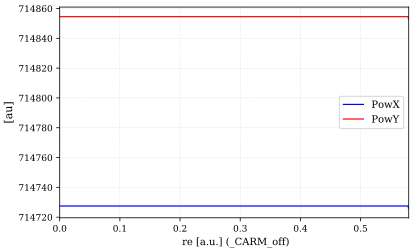

In [98]:
CARMtofreqpow(ULbase)

Parsing `set DARM_err AS_DC re` into pykat object not implemented yet, added as extra line.
Parsing `set CARM_sig REFL_f1_I re` into pykat object not implemented yet, added as extra line.
Parsing `set PRCL_err POP_f1_I re` into pykat object not implemented yet, added as extra line.
Parsing `set MICH_err POP_f2_Q re` into pykat object not implemented yet, added as extra line.
Parsing `set SRCL_err REFL_f2_I re` into pykat object not implemented yet, added as extra line.
Parsing `set CARM_off _CARM_off re` into pykat object not implemented yet, added as extra line.
Parsing `set _PRM_phi PRM phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ITMX_phi ITMX phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ITMY_phi ITMY phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ETMX_phi ETMX phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ETMY_phi ETMY phi` into pykat object not imple

/Users/annagreen/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: parseCommands depreciated, use parse.
100% | ETA:  0:00:00 | Calculating - Locked ✓✓✓✓✓ (Locking steps tried 0/10000))

Used Finesse 2.2 at /Users/annagreen/GIT/Finesse/finesse/kat

Finished in 65.1305 seconds


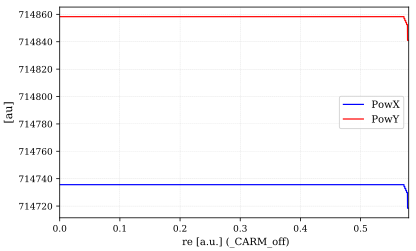

In [99]:
testbase = ULbase.deepcopy()
testbase.LY.L += 5e-2
CARMtofreqpow(testbase)

In [116]:
from LHO import make_LHO
LHO = make_LHO(aligo.make_kat())
LHO.maxtem =4
LHO = aligo.setup(LHO,verbose=True)

testk = LHO.deepcopy()
testk.removeBlock("locks")

CARMtofreqpow(testk,frange=3)


aLIGO name `design_with_IMC_HAM2_FI_OMC' not recognised,
options are ['design'], using default 'design'


Pykat parsing does not preserve inline comments. Moving inline
comments before command

--------------------------------------
Lengths
--------------------------------------
lx (BShr to ITMXhr) = 5.3846 m
ly (BShr to ITMYhr) = 5.3005 m
Schnupp (lx - ly) = 0.0842 m
lpr = 52.3135 m
PRC = 57.6561 m
-- pretuning interferometer to precision 0.001 deg = 2.95556e-12 m
   scanning X arm (maximising power)
   found max/min at: 0 (precision = 0.00030375)
   scanning Y arm (maximising power)
   found max/min at: 0 (precision = 0.00030375)
   scanning MICH (minimising power)
   found max/min at: 0.593 (precision = 0.00010125)
   scanning PRCL (maximising power)
   found max/min at: -0.164 (precision = 0.00030375)
   scanning SRCL (maximising carrier power, then adding 90 deg)
   found max/min at: -76.674 (precision = 0.00030375)
   ... done
-- adjusting PRC length
   adusting kat.lp1.L by 0.0

/Users/annagreen/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: parseCommands depreciated, use parse.
  1% | ETA:  2:45:24 | Calculating - Locked X✓✓✓✓ (Locking steps tried 1693/10000)


Keyboard interrupt caught, stopped simulation.


Finished in 101.61 seconds


AttributeError: 'NoneType' object has no attribute 'plot'

In [117]:
ULhan = LHO.deepcopy()
ULhan.removeBlock("locks")

4
4


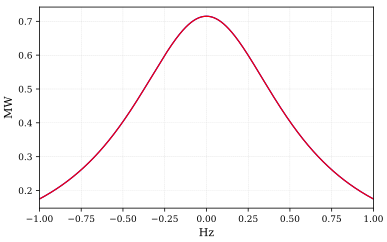

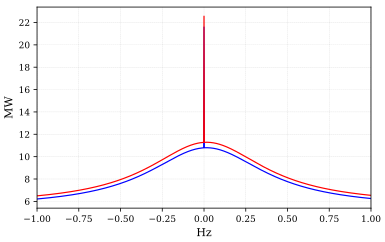

In [127]:
for bb in [ULbase,ULhan]:
    kat = bb.deepcopy()
#     print(kat.maxtem)
    kat.parse("xaxis L0 f lin -1 1 1000")
    kat.IFO.POW_X.add_signal()
    kat.IFO.POW_Y.add_signal()
    o=kat.run()
    plt.figure()
    plt.plot(o.x,o[kat.IFO.POW_X.name]/1e6,label='X')
    plt.plot(o.x,o[kat.IFO.POW_Y.name]/1e6,label='Y')
    plt.ylabel('MW')
    plt.xlabel('Hz')

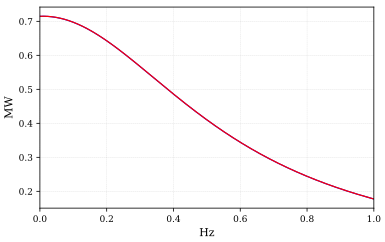

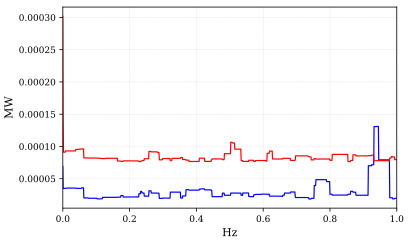

In [130]:
for bb in [ULbase,ULhan]:
    kat = bb.deepcopy()
#     print(kat.maxtem)
    kat.parse("xaxis L0 f lin 0 1 1000")
    kat.addLine("""
    %%% FTblock locks
    set DARM_err AS_DC re
    set CARM_err REFL_f1_I re
    set PRCL_err POP_f1_I re
    set MICH_err POP_f2_Q re
    set SRCL_err REFL_f2_I re
    lock* DARM_lock $DARM_err -0.0027 0.0062 -0.309907882576331
    lock* CARM_lock $CARM_err -5.9e-07 0.29
    lock* PRCL_lock $PRCL_err -3.0 0.00011
    lock* MICH_lock $MICH_err 48.0 3.5e-05
    lock* SRCL_lock $SRCL_err 0.098 0.043
    noplot ETMX_lock
    func ETMX_lock = (-1.0) * $CARM_lock - 0.5 * $MICH_lock - $DARM_lock
    put* ETMX phi $ETMX_lock
    noplot ETMY_lock
    func ETMY_lock = (-1.0) * $CARM_lock + 0.5 * $MICH_lock + $DARM_lock
    put* ETMY phi $ETMY_lock
    noplot ITMX_lock
    func ITMX_lock = (-0.5) * $MICH_lock
    put* ITMX phi $ITMX_lock
    noplot ITMY_lock
    func ITMY_lock = 0.5 * $MICH_lock
    put* ITMY phi $ITMY_lock
    noplot PRM_lock
    func PRM_lock = 1.0 * $PRCL_lock
    put* PRM phi $PRM_lock
    noplot SRM_lock
    func SRM_lock = (-1.0) * $SRCL_lock
    put* SRM phi $SRM_lock
    %%% FTend locks""")
    kat.IFO.POW_X.add_signal()
    kat.IFO.POW_Y.add_signal()
    o=kat.run()
    plt.figure()
    plt.plot(o.x,o[kat.IFO.POW_X.name]/1e6,label='X')
    plt.plot(o.x,o[kat.IFO.POW_Y.name]/1e6,label='Y')
    plt.ylabel('MW')
    plt.xlabel('Hz')

--------------------

In [67]:
kat = ULbase.deepcopy()
kat.verbose=True
#replacement lock block:
kat.parse("""
%%% FTblock locks
set DARM_err AS_DC re
set CARM_sig REFL_f1_I re
set PRCL_err POP_f1_I re
set MICH_err POP_f2_Q re
set SRCL_err REFL_f2_I re
lock DARM_lock $DARM_err -0.0027 0.0062 -0.309907882576331
###new version
var _CARM_off 0.0
set CARM_off _CARM_off re

func CARM_err=$CARM_sig + $CARM_off
lock CARM_lock $CARM_err -5.9e-07 0.29 
###
lock PRCL_lock $PRCL_err -3.0 0.00011
lock MICH_lock $MICH_err 48.0 3.5e-05
lock SRCL_lock $SRCL_err 0.098 0.043
noplot ETMX_lock
func ETMX_lock = (-1.0) * $CARM_lock - 0.5 * $MICH_lock - $DARM_lock
put* ETMX phi $ETMX_lock
noplot ETMY_lock
func ETMY_lock = (-1.0) * $CARM_lock + 0.5 * $MICH_lock + $DARM_lock
put* ETMY phi $ETMY_lock
noplot ITMX_lock
func ITMX_lock = (-0.5) * $MICH_lock
put* ITMX phi $ITMX_lock
noplot ITMY_lock
func ITMY_lock = 0.5 * $MICH_lock
put* ITMY phi $ITMY_lock
noplot PRM_lock
func PRM_lock = 1.0 * $PRCL_lock
put* PRM phi $PRM_lock
noplot SRM_lock
func SRM_lock = (-1.0) * $SRCL_lock
put* SRM phi $SRM_lock
%%% FTend locks""")
#xaxis:
kat.parse("""
xaxis _CARM_off re lin 0 0.58 3000
""")
#detectors:
kat.IFO.POW_X.add_signal()
kat.IFO.POW_Y.add_signal()
#saving mirror tunings:
mirs = [kat.PRM, 
       kat.ITMX, 
       kat.ITMY, 
       kat.ETMX, 
       kat.ETMY, 
       kat.SRM]
for m in mirs:
    kat.parseCommands("""
    set _{mirror}_phi {mirror} phi
    func {mirror}_phi = $_{mirror}_phi 
    """.format(mirror=m.name))
#running
out=kat.run()

Parsing `set DARM_err AS_DC re` into pykat object not implemented yet, added as extra line.
Parsing `set CARM_sig REFL_f1_I re` into pykat object not implemented yet, added as extra line.
Parsing `set PRCL_err POP_f1_I re` into pykat object not implemented yet, added as extra line.
Parsing `set MICH_err POP_f2_Q re` into pykat object not implemented yet, added as extra line.
Parsing `set SRCL_err REFL_f2_I re` into pykat object not implemented yet, added as extra line.
Parsing `set CARM_off _CARM_off re` into pykat object not implemented yet, added as extra line.
Parsing `set _PRM_phi PRM phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ITMX_phi ITMX phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ITMY_phi ITMY phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ETMX_phi ETMX phi` into pykat object not implemented yet, added as extra line.
Parsing `set _ETMY_phi ETMY phi` into pykat object not imple

/Users/annagreen/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: parseCommands depreciated, use parse.
100% | ETA:  0:00:00 | Calculating - Locked ✓✓✓✓✓ (Locking steps tried 0/10000))

Used Finesse 2.2 at /Users/annagreen/GIT/Finesse/finesse/kat

Finished in 64.0069 seconds


100% | ETA:  0:00:00 | Calculating - Locked ✓✓✓✓✓ (Locking steps tried 0/10000)

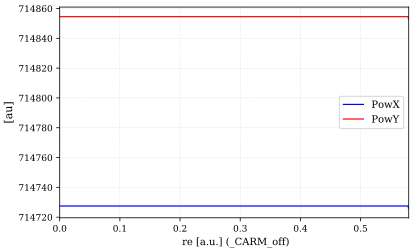

In [68]:
#X and Y arm powers with CARM lock offset:
out.plot([kat.IFO.POW_X.name,kat.IFO.POW_Y.name])

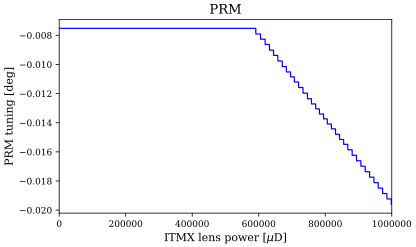

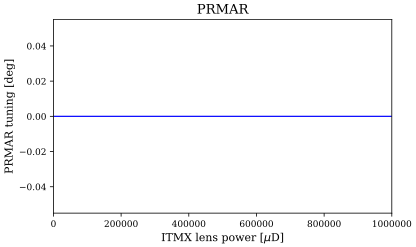

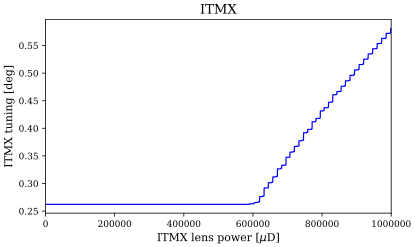

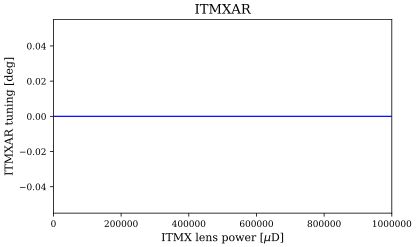

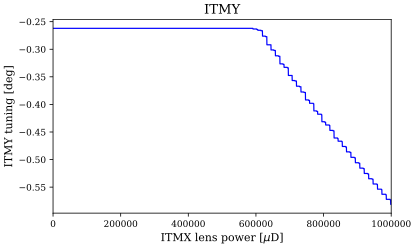

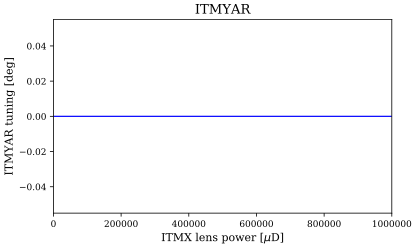

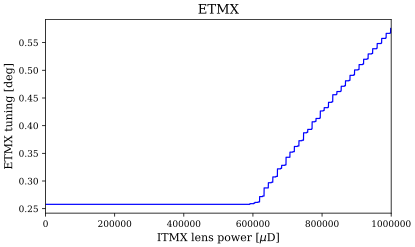

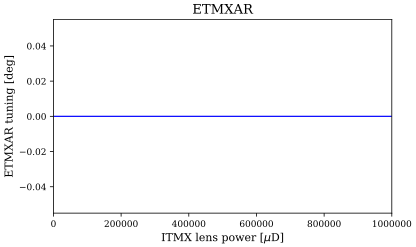

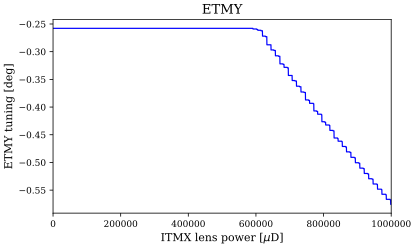

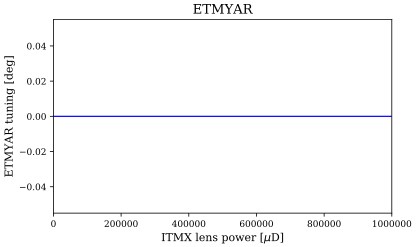

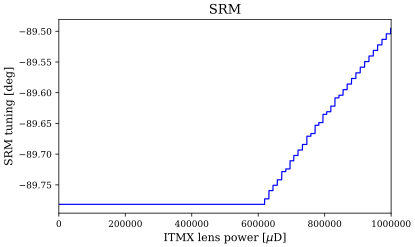

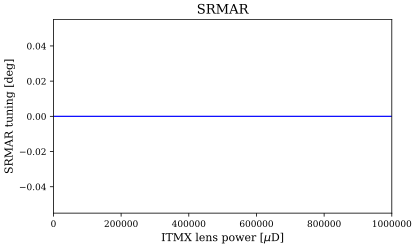

In [60]:
uD = 1e6
#mirror tunings:
for m in mirs:
    plt.figure()
    plt.plot(out.x*uD, out["{mirror}_phi".format(mirror=m.name)], 'b')
    plt.ylabel("{mirror} tuning [deg]".format(mirror=m.name))
    plt.xlabel("ITMX lens power [$\mu$D]")
    plt.title(m.name)
    plt.tight_layout()

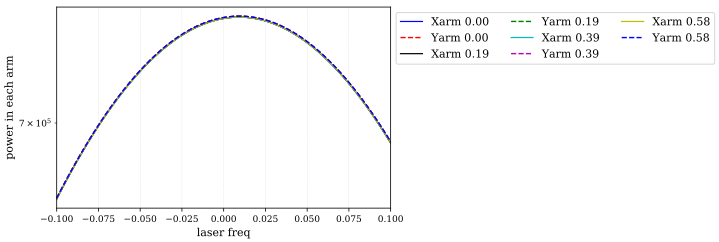

In [92]:
Fscans = []
for ii in range(len(out.x)):
    if ii%1000 == 0:
        offs = out.x[ii]
        kk = ULbase.deepcopy()
        mirs = [kk.PRM, 
           kk.ITMX, 
           kk.ITMY, 
           kk.ETMX, 
           kk.ETMY, 
           kk.SRM]
        for m in mirs:
            m.phi = out["{mirror}_phi".format(mirror=m.name)][ii]
        kk.parse("""
        xaxis L0 f lin -1e-1 1e-1 100
        pd Pout nAS
        pd PX nITMX2
        pd PY nITMY2""")
        oo=kk.run()
        plt.semilogy(oo.x,oo['PX'],label = "Xarm {:.2f}".format(offs))
        plt.semilogy(oo.x,oo['PY'],label = "Yarm {:.2f}".format(offs), ls='--', lw=1.4)
        Fscans.append(oo)
plt.xlabel('laser freq')
plt.ylabel('power in each arm')
plt.legend(loc=2, bbox_to_anchor = (1,1),ncol=3)

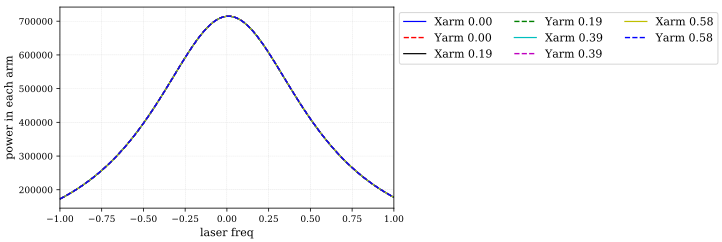

In [95]:
## DELIBERATELY ADDING IN SOME MISMATCH IN THE YARM
Fscans = []
for ii in range(len(out.x)):
    if ii%1000 == 0:
        offs = out.x[ii]
        kk = ULbase.deepcopy()
#         kk.ETMY.Rc *=1.1 #####HERE
        kk.LY.L +=5e-2
#         kk.ETMY.setRTL(kk.ETMY.R-1e-6, kk.ETMY.T, kk.ETMY.L+1e-6)
        mirs = [kk.PRM, 
           kk.ITMX, 
           kk.ITMY, 
           kk.ETMX, 
           kk.ETMY, 
           kk.SRM]
        for m in mirs:
            m.phi = out["{mirror}_phi".format(mirror=m.name)][ii]
        kk.parse("""
        xaxis L0 f lin -1 1 100
        pd Pout nAS
        pd PX nITMX2
        pd PY nITMY2""")
        oo=kk.run()
        plt.plot(oo.x,oo['PX'],label = "Xarm {:.2f}".format(offs))
        plt.plot(oo.x,oo['PY'],label = "Yarm {:.2f}".format(offs), ls='--', lw=1.4)
        Fscans.append(oo)
plt.xlabel('laser freq')
plt.ylabel('power in each arm')
plt.legend(loc=2, bbox_to_anchor = (1,1),ncol=3)